In [3]:
import json
import glob
from pathlib import Path
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from scipy.stats import fisher_exact, norm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, cohen_kappa_score, classification_report, precision_recall_fscore_support
)
import scikits.bootstrap as boot
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns


In [175]:

def bca_kappa_ci(y_true, y_pred, n_resamples=5000, alpha=0.05, random_state=None):
    rng = np.random.default_rng(random_state)
    data = np.array(list(zip(y_true, y_pred)))
    n = len(data)

    def kappa_fn(sample):
        y_t, y_p = zip(*sample)
        return cohen_kappa_score(y_t, y_p)

    # Point estimate
    theta_hat = kappa_fn(data)

    # Bootstrap distribution
    thetas = []
    for _ in range(n_resamples):
        idx = rng.choice(n, size=n, replace=True)
        sample = data[idx]
        thetas.append(kappa_fn(sample))
    thetas = np.array(thetas)

    # z0: bias correction
    z0 = norm.ppf((thetas < theta_hat).mean())

    # Jackknife for acceleration factor
    jack_thetas = []
    for i in range(n):
        jack_sample = np.delete(data, i, axis=0)
        jack_thetas.append(kappa_fn(jack_sample))
    jack_thetas = np.array(jack_thetas)
    jack_mean = jack_thetas.mean()
    numer = np.sum((jack_mean - jack_thetas)**3)
    denom = 6 * (np.sum((jack_mean - jack_thetas)**2))**1.5
    acc = numer / denom if denom != 0 else 0

    # Adjusted quantiles
    z_alpha_low = norm.ppf(alpha / 2)
    z_alpha_high = norm.ppf(1 - alpha / 2)

    pct_low = norm.cdf(z0 + (z0 + z_alpha_low) / (1 - acc * (z0 + z_alpha_low)))
    pct_high = norm.cdf(z0 + (z0 + z_alpha_high) / (1 - acc * (z0 + z_alpha_high)))

    ci_low = np.percentile(thetas, 100 * pct_low)
    ci_high = np.percentile(thetas, 100 * pct_high)

    return {
        "cohen_kappa": theta_hat,
        "cohen_kappa_lower": ci_low,
        "cohen_kappa_upper": ci_high
    }


from sklearn.utils import resample
from collections import defaultdict

def analyze_hard_case_correlation_bootstrap(x, y_true, y_pred):
    """
    Analyze error rates for hard vs. easy cases.

    Parameters:
    - x: list of keys (same order as y_true and y_pred)
    - y_true: list of ground truth labels
    - y_pred: list of predicted labels
    - hard_flags: dict mapping each key to a boolean (True=hard, False=easy)

    Returns:
    - error_summary: dict with counts and error rates per category
    """
    assert len(x) == len(y_true) == len(y_pred), "All input lists must have the same length"

    gold_path = "evaluation/human_results.jsonl"
    _ , hard_flags, _ = load_verdicts(gold_path)

    results = defaultdict(lambda: {'total': 0, 'errors': 0})

    for key, true_label, pred_label in zip(x, y_true, y_pred):
        is_hard = hard_flags.get(key, False)
        results[is_hard]['total'] += 1
        if pred_label != true_label:
            results[is_hard]['errors'] += 1

    error_summary = {}
    for hard_status, stats in results.items():
        total = stats['total']
        errors = stats['errors']
        error_rate = errors / total if total > 0 else 0
        label = 'hard' if hard_status else 'easy'
        error_summary[f"{label}_total"] = total
        error_summary[f"{label}_errors"] = errors
        error_summary[f"{label}_error_rate"] = round(error_rate * 100, 2)  # as percentage
        #print(f"{label.capitalize()} cases: {errors} errors out of {total} → {error_rate:.2%}")

    return error_summary

def bootstrap_metrics_stratified(y_true, y_pred, x, labels, n_bootstrap=5000, ci=95, random_state=42, rates=True):
    rng = np.random.default_rng(random_state)
    class_indices = defaultdict(list)

    for i, label in enumerate(y_true):
        class_indices[label].append(i)

    metrics = {
        "accuracy": [],
        "macro_f1": [],
        "macro_precision": [],
        "macro_recall": [],
        "precision_per_class": {label: [] for label in labels},
        "recall_per_class": {label: [] for label in labels},
        "hard_errors": [],
        "easy_errors": [],
        "hard_error_rate": [],
        "easy_error_rate": []
    }

    for _ in range(n_bootstrap):
        resampled_indices = []
        for label in labels:
            idxs = class_indices.get(label, [])
            if not idxs:
                continue
            n_samples = len(idxs)
            resampled = rng.choice(idxs, size=n_samples, replace=True)
            resampled_indices.extend(resampled)

        if not resampled_indices:
            print('Resampled indices are empty, skipping this iteration.')
            break

        sample_y_true = [y_true[i] for i in resampled_indices]
        sample_y_pred = [y_pred[i] for i in resampled_indices]
        if rates:
            sample_keys = [x[i] for i in resampled_indices]

            sample_y_true_with_keys = list(zip(sample_keys, sample_y_true))
            sample_y_pred_with_keys = list(zip(sample_keys, sample_y_pred))

        try:

            # Compute metrics
            metrics["accuracy"].append(accuracy_score(sample_y_true, sample_y_pred))
            metrics["macro_f1"].append(f1_score(sample_y_true, sample_y_pred, average='macro', labels =labels, zero_division=0))
            metrics["macro_precision"].append(precision_score(sample_y_true, sample_y_pred, average='macro', labels =labels, zero_division=0))
            metrics["macro_recall"].append(recall_score(sample_y_true, sample_y_pred, average='macro', labels =labels, zero_division=0))
            if rates:
                metrics['hard_errors'].append(analyze_hard_case_correlation_bootstrap(sample_keys, sample_y_true_with_keys, sample_y_pred_with_keys)['hard_errors'])
                metrics['easy_errors'].append(analyze_hard_case_correlation_bootstrap(sample_keys, sample_y_true_with_keys, sample_y_pred_with_keys)['easy_errors'])
                metrics["hard_error_rate"].append(analyze_hard_case_correlation_bootstrap(sample_keys, sample_y_true_with_keys, sample_y_pred_with_keys)['hard_error_rate'])
                metrics["easy_error_rate"].append(analyze_hard_case_correlation_bootstrap(sample_keys, sample_y_true_with_keys, sample_y_pred_with_keys)['easy_error_rate'])

            precisions = precision_score(sample_y_true, sample_y_pred, labels=labels, average=None, zero_division=0)
            recalls = recall_score(sample_y_true, sample_y_pred, labels=labels, average=None, zero_division=0)

            for i, label in enumerate(labels):
                metrics["precision_per_class"][label].append(precisions[i])
                metrics["recall_per_class"][label].append(recalls[i])

        except Exception:
            continue
    
    result = {}

    if rates:
        error_diff = [h - e for h, e in zip(metrics['hard_error_rate'], metrics['easy_error_rate'])]
        mean_diff = np.mean(error_diff)
        p_value = np.mean([d <= 0 for d in error_diff]) if mean_diff > 0 else np.mean([d >= 0 for d in error_diff])

        result['error_rate_diff'] = error_diff
        result['error_rate_diff_mean'] = mean_diff
        result['error_rate_diff_p_value'] = p_value

    # Compute CI
    def ci_bounds(values):
        values = np.array(values)
        return values.mean(), np.percentile(values, (100 - ci)/2), np.percentile(values, 100 - (100 - ci)/2)

    for k in ["accuracy", "macro_f1", "macro_precision", "macro_recall"]:
        mean, lower, upper = ci_bounds(metrics[k])
        result[f"{k}_mean"] = mean
        result[f"{k}_ci_lower"] = lower
        result[f"{k}_ci_upper"] = upper

    if rates:
        for k in ["hard_error_rate", "easy_error_rate", "hard_errors", "easy_errors"]:
            mean, lower, upper = ci_bounds(metrics[k])
            result[f"{k}_mean"] = mean
            result[f"{k}_ci_lower"] = lower
            result[f"{k}_ci_upper"] = upper

    for label in labels:
        p_mean, p_lo, p_hi = ci_bounds(metrics["precision_per_class"][label])
        r_mean, r_lo, r_hi = ci_bounds(metrics["recall_per_class"][label])
        result[f"precision_{label}"] = p_mean
        result[f"precision_{label}_lower"] = p_lo
        result[f"precision_{label}_upper"] = p_hi
        result[f"recall_{label}"] = r_mean
        result[f"recall_{label}_lower"] = r_lo
        result[f"recall_{label}_upper"] = r_hi
    

    return result


# Load and normalize verdicts (handles capital letters, trailing spaces, and malformed entries)
def load_verdicts(jsonl_path):
    verdicts = {}
    hard_flags = {}
    skipped = 0
    with open(jsonl_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                entry = json.loads(line)
                key, value = next(iter(entry.items()))
                if isinstance(value, dict) and 'verdict' in value:
                    verdict = value['verdict'].strip().lower()
                    verdicts[key] = verdict
                    hard_flags[key] = value.get('confidence', '').strip().lower() == 'low'
                else:
                    skipped += 1
            except Exception:
                skipped += 1
    return verdicts, hard_flags, skipped

# Multiclass evaluation with label normalization and full label set
def evaluate_multiclass(y_true, y_pred, labels):
    print("Class distribution (gold):", Counter(y_true))
    print("Class distribution (pred):", Counter(y_pred))
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "macro_precision": precision_score(y_true, y_pred, average='macro', zero_division=0),
        "macro_recall": recall_score(y_true, y_pred, average='macro', zero_division=0),
        "macro_f1": f1_score(y_true, y_pred, average='macro', zero_division=0),
        "weighted_f1": f1_score(y_true, y_pred, average='weighted', zero_division=0),
        "confusion_matrix": confusion_matrix(y_true, y_pred, labels=labels).tolist(),
    }

# Binary evaluation (excluding 'unclear')
def evaluate_binary(y_true, y_pred):
    label_map = {'same': 1, 'different': 0}
    y_true_bin = [label_map[v] for v in y_true]
    y_pred_bin = [label_map[v] for v in y_pred]

    return {
        "accuracy": accuracy_score(y_true_bin, y_pred_bin),
        "precision": precision_score(y_true_bin, y_pred_bin, zero_division=0),
        "recall": recall_score(y_true_bin, y_pred_bin, zero_division=0),
        "f1": f1_score(y_true_bin, y_pred_bin, zero_division=0),
        "confusion_matrix": confusion_matrix(y_true_bin, y_pred_bin).tolist()
    }

# Confusion matrix heatmap

def plot_confusion_matrix_heatmap(conf_matrix, labels, model_name):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(model_name)
    plt.tight_layout()
    plt.savefig(f"figures/confusion_matrix_{model_name}.png", dpi=300, bbox_inches='tight')

    plt.show()


# Analyze correlation of model errors with human-marked hard cases
def analyze_hard_case_correlation(model_verdicts, gold_verdicts, hard_flags):
    results = defaultdict(lambda: {'total': 0, 'errors': 0})

    for key in model_verdicts:
        if key not in gold_verdicts:
            continue
        true_label = gold_verdicts[key]
        pred_label = model_verdicts[key]
        is_hard = hard_flags.get(key, False)
        results[is_hard]['total'] += 1
        if pred_label != true_label:
            results[is_hard]['errors'] += 1

    error_summary = {}
    for hard_status, stats in results.items():
        total = stats['total']
        errors = stats['errors']
        error_rate = errors / total if total > 0 else 0
        label = 'hard' if hard_status else 'easy'
        error_summary[f"{label}_total"] = total
        error_summary[f"{label}_errors"] = errors
        error_summary[f"{label}_error_rate"] = round(error_rate * 100, 2)  # as percentage
        print(f"{label.capitalize()} cases: {errors} errors out of {total} → {error_rate:.2%}")

    

    return error_summary

# Main evaluation loop
def evaluate_all_models_plot(gold_path, model_pattern="evaluation/results_*.jsonl"):
    gold_verdicts, hard_flags, gold_skipped = load_verdicts(gold_path)
    model_files = glob.glob(model_pattern)
    labels = ['same', 'different', 'unclear']

    metrics_summary = []
    confusion_matrices = {}

    for model_file in model_files:
        model_name = Path(model_file).stem.replace("results_", "")
        model_verdicts, _, model_skipped = load_verdicts(model_file)

        common_keys = model_verdicts.keys() & gold_verdicts.keys()

        if not common_keys:
            print(f"⚠️  Skipping model '{model_name}' — no common entries with gold standard.")
            continue

        x = list(common_keys)
        y_true = [gold_verdicts[k] for k in x]
        y_pred = [model_verdicts[k] for k in x]


        print("Label order:", labels)

        try:
            multiclass = evaluate_multiclass(y_true, y_pred, labels)
            #plot_confusion_matrix_heatmap(multiclass["confusion_matrix"], labels, title=model_name)
            confusion_matrices[model_name] = multiclass["confusion_matrix"]

            # Precision and recall per class
            precisions, recalls, _, _ = precision_recall_fscore_support(
                y_true, y_pred, labels=labels, zero_division=0
            )

            # Macro-averaged precision and recall
            macro_precision = sum(precisions) / len(precisions)
            macro_recall = sum(recalls) / len(recalls)
            
            error_stats = analyze_hard_case_correlation(model_verdicts, gold_verdicts, hard_flags)

            # Run Fisher's test
            fisher = test_significance_of_error_difference(
                hard_errors=error_stats['hard_errors'],
                hard_total=error_stats['hard_total'],
                easy_errors=error_stats['easy_errors'],
                easy_total=error_stats['easy_total']
            )
            error_stats.update(fisher)

            # Compute bootstrap confidence intervals
            bootstrap = bootstrap_metrics_stratified(y_true, y_pred, x, labels)

            metrics_summary.append({
                "model": model_name,
                "accuracy": bootstrap["accuracy_mean"],
                "macro_f1": bootstrap["macro_f1_mean"],
                "accuracy_lower": bootstrap["accuracy_ci_lower"],
                "accuracy_upper": bootstrap["accuracy_ci_upper"],
                "macro_f1_lower": bootstrap["macro_f1_ci_lower"],
                "macro_f1_upper": bootstrap["macro_f1_ci_upper"],
                "macro_precision": macro_precision,
                "macro_recall": macro_recall,
                "precision_same": precisions[0],
                "recall_same": recalls[0],
                "precision_different": precisions[1],
                "recall_different": recalls[1],
                "precision_unclear": precisions[2],
                "recall_unclear": recalls[2],
                "macro_precision_lower": bootstrap["macro_precision_ci_lower"],
                "macro_precision_upper": bootstrap["macro_precision_ci_upper"],
                "macro_recall_lower": bootstrap["macro_recall_ci_lower"],
                "macro_recall_upper": bootstrap["macro_recall_ci_upper"],
                "precision_same_lower": bootstrap["precision_same_lower"],
                "precision_same_upper": bootstrap["precision_same_upper"],
                "precision_different_lower": bootstrap["precision_different_lower"],
                "precision_different_upper": bootstrap["precision_different_upper"],
                "precision_unclear_lower": bootstrap["precision_unclear_lower"],
                "precision_unclear_upper": bootstrap["precision_unclear_upper"],
                "recall_same_lower": bootstrap["recall_same_lower"],
                "recall_same_upper": bootstrap["recall_same_upper"],
                "recall_different_lower": bootstrap["recall_different_lower"],
                "recall_different_upper": bootstrap["recall_different_upper"],
                "recall_unclear_lower": bootstrap["recall_unclear_lower"],
                "recall_unclear_upper": bootstrap["recall_unclear_upper"],
                "hard_error_rate": bootstrap["hard_error_rate_mean"],
                "hard_error_rate_lower": bootstrap["hard_error_rate_ci_lower"],
                "hard_error_rate_upper": bootstrap["hard_error_rate_ci_upper"],
                "easy_error_rate": bootstrap["easy_error_rate_mean"],
                "easy_error_rate_lower": bootstrap["easy_error_rate_ci_lower"],
                "easy_error_rate_upper": bootstrap["easy_error_rate_ci_upper"],
                'error_rate_diff': bootstrap["error_rate_diff"],
                'error_rate_diff_mean': bootstrap["error_rate_diff_mean"],
                'error_rate_diff_p_value': bootstrap["error_rate_diff_p_value"],
                "hard_errors": bootstrap['hard_errors_mean'],
                "hard_errors_lower": bootstrap['hard_errors_ci_lower'],
                "hard_errors_upper": bootstrap['hard_errors_ci_upper'],
                "easy_errors": bootstrap['easy_errors_mean'],
                "easy_errors_lower": bootstrap['easy_errors_ci_lower'],
                "easy_errors_upper": bootstrap['easy_errors_ci_upper'],
                "skipped_entries": model_skipped
            })


            print(f"\n🔍 Hard case error analysis for model: {model_name}")
            analyze_hard_case_correlation(model_verdicts, gold_verdicts, hard_flags)

        except Exception as e:
            print(f"❌ Failed to evaluate model '{model_name}': {e}")
            raise

    if not metrics_summary:
        print("No valid model evaluations to plot.")
        return

    df = pd.DataFrame(metrics_summary)

    name_mapping = {
        'mixtral_8x7b_instruct_v0.1': 'Mixtral 8x7B',
        'mixtral-8x22b-instruct': 'Mixtral 8x22B',
        'Llama-4-Maverick-17B-128E-Instruct': 'Llama 4 Maverick',
        'mistral_7b_instruct_v0.3': 'Mistral 7B',
        'gpt_4o': 'GPT-4o',
        'Llama-4-Scout-17B-16E-Instruct': 'Llama 4 Scout',
        'ministral_8b': 'Ministral 8B',
        'openchat_7b': 'OpenChat',
        'llama_3.3_70b_instruct': 'Llama 3.3'
    }

    # Apply the renaming
    df['model'] = df['model'].replace(name_mapping)

    if 'model' not in df.columns:
        print("Missing 'model' column in metrics summary.")
        print(df)
        return

    #df.set_index("model", inplace=True)

    # High-level metrics
    metrics_to_print = [
        ("accuracy", "Accuracy"),
        ("macro_f1", "Macro F1-score"),
        ("macro_precision", "Macro Precision"),
        ("macro_recall", "Macro Recall"),
        ("hard_error_rate", "Hard Error Rate"),
        ("easy_error_rate", "Easy Error Rate")
    ]

    for metric, label in metrics_to_print:
        print(f"\n📊 {label} Confidence Intervals:")
        for _, row in df.iterrows():
            model = row["model"]
            mean = row[metric]
            lower = row[f"{metric}_lower"]
            upper = row[f"{metric}_upper"]
            print(f"  {model:20s}: {mean:.3f}  ({lower:.3f} – {upper:.3f})")

    # error rates
    print("\n📊 Error Rates:")
    metrics_to_print = {
        'error_rate_diff_p_value': 'Error Rate Diff P-value', 
        'error_rate_diff_mean': 'Error Rate Diff Mean',}
    for metric in metrics_to_print:
        print(f"\n📊 {metrics_to_print[metric]}:")
        for _, row in df.iterrows():
            model = row["model"]
            mean = row[metric]
            print(f"  {model:20s}: {mean:.3f}")

    # Per-class metrics
    labels = ['same', 'different', 'unclear']  # or dynamically from your config

    for label in labels:
        print(f"\n📊 Precision and Recall for class '{label}':")
        for _, row in df.iterrows():
            model = row['model']
            p = row[f'precision_{label}']
            p_lo = row[f'precision_{label}_lower']
            p_hi = row[f'precision_{label}_upper']
            r = row[f'recall_{label}']
            r_lo = row[f'recall_{label}_lower']
            r_hi = row[f'recall_{label}_upper']

            print(f"  {model:20s}: "
                f"Precision = {p:.3f} ({p_lo:.3f} – {p_hi:.3f}) | "
                f"Recall = {r:.3f} ({r_lo:.3f} – {r_hi:.3f})")


    # Adding errors for bar plots

    # Sort models by descending accuracy
    accuracy_order = df.sort_values("accuracy", ascending=False)["model"]

    # Melt the DataFrame to long format
    df_long = df.melt(id_vars='model', 
                    value_vars=["accuracy", "macro_f1"], 
                    var_name='Metric', 
                    value_name='Score')
    
    # Add error bars to long format
    error_mapping = {
        "accuracy": ("accuracy_err_low", "accuracy_err_high"),
        "macro_f1": ("macro_f1_err_low", "macro_f1_err_high"),
    }

    df["accuracy_err_low"] = df["accuracy"] - df["accuracy_lower"]
    df["accuracy_err_high"] = df["accuracy_upper"] - df["accuracy"]
    df["macro_f1_err_low"] = df["macro_f1"] - df["macro_f1_lower"]
    df["macro_f1_err_high"] = df["macro_f1_upper"] - df["macro_f1"]

    df_long["err_low"] = df_long.apply(lambda row: df.loc[df["model"] == row["model"], error_mapping[row["Metric"]][0]].values[0], axis=1)
    df_long["err_high"] = df_long.apply(lambda row: df.loc[df["model"] == row["model"], error_mapping[row["Metric"]][1]].values[0], axis=1)

   
    # Create a display name mapping
    metric_labels = {
        "accuracy": "Accuracy",
        "macro_f1": "Macro F1-score",
    }

    # Replace metric names in df_long
    df_long['Metric'] = df_long['Metric'].map(metric_labels)
    

    return df, confusion_matrices



def plot_horizontal_errorbars(df, colors, filename="horizontal_metrics", size=(12, 4.5)):
    # Sort by accuracy for consistent ordering
    df = df.sort_values("accuracy", ascending=False)

    # Plot style
    sns.set_theme(style="ticks", context="paper", font_scale=1.4)

    # Extract colors from the palette
    color_acc = colors[0]
    color_f1 = colors[1]

    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=size, sharey=True)

    # --- Accuracy ---
    axes[0].errorbar(
        df['accuracy'], df['model'],
        xerr=[df['accuracy'] - df['accuracy_lower'], df['accuracy_upper'] - df['accuracy']],
        fmt='o', capsize=4, color=color_acc
    )
    axes[0].set_title("Accuracy with 95% CI")
    axes[0].set_xlim(0.0, 1.0)
    axes[0].set_xlabel("Score")

    # --- Macro F1-score ---
    axes[1].errorbar(
        df['macro_f1'], df['model'],
        xerr=[df['macro_f1'] - df['macro_f1_lower'], df['macro_f1_upper'] - df['macro_f1']],
        fmt='o', capsize=4, color=color_f1
    )
    axes[1].set_title("Macro F1-score with 95% CI")
    axes[1].set_xlim(0.0, 1.0)
    axes[1].set_xlabel("Score")

    # Layout
    plt.tight_layout()
    plt.savefig(f"../figures/{filename}.png", dpi=300, bbox_inches='tight')
    plt.show()


def test_significance_of_error_difference(hard_errors, hard_total, easy_errors, easy_total):
    # Construct contingency table:
    #           Error  Correct
    # Hard      a      b
    # Easy      c      d
    a = hard_errors
    b = hard_total - hard_errors
    c = easy_errors
    d = easy_total - easy_errors

    table = [[a, b], [c, d]]

    odds_ratio, p_value = fisher_exact(table, alternative='two-sided')

    print("\n📊 Fisher's Exact Test Results:")
    print(f"Contingency Table: {table}")
    print(f"Odds Ratio: {odds_ratio:.4f}")
    print(f"P-value: {p_value:.4f}")

    return {"p_value": p_value, "odds_ratio": odds_ratio}


In [176]:
df_results, confusion_matrices = evaluate_all_models_plot("evaluation/human_results.jsonl")

Label order: ['same', 'different', 'unclear']
Class distribution (gold): Counter({'same': 77, 'different': 16, 'unclear': 3})
Class distribution (pred): Counter({'same': 84, 'different': 12})
Easy cases: 6 errors out of 73 → 8.22%
Hard cases: 3 errors out of 23 → 13.04%

📊 Fisher's Exact Test Results:
Contingency Table: [[3, 20], [6, 67]]
Odds Ratio: 1.6750
P-value: 0.4436

🔍 Hard case error analysis for model: mixtral_8x7b_instruct_v0.1
Easy cases: 6 errors out of 73 → 8.22%
Hard cases: 3 errors out of 23 → 13.04%
Label order: ['same', 'different', 'unclear']
Class distribution (gold): Counter({'same': 79, 'different': 18, 'unclear': 3})
Class distribution (pred): Counter({'same': 74, 'different': 26})
Easy cases: 8 errors out of 76 → 10.53%
Hard cases: 8 errors out of 24 → 33.33%

📊 Fisher's Exact Test Results:
Contingency Table: [[8, 16], [8, 68]]
Odds Ratio: 4.2500
P-value: 0.0208

🔍 Hard case error analysis for model: mixtral-8x22b-instruct
Easy cases: 8 errors out of 76 → 10.53%


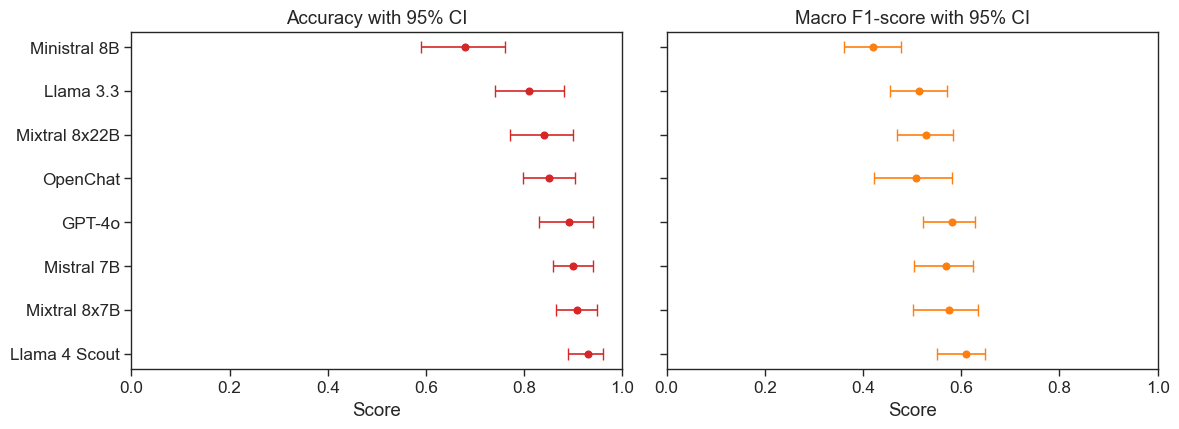

In [151]:
plot_horizontal_errorbars(df_results, ['tab:red', 'tab:orange'], filename='model_accuracy_macro_f1')

In [170]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

def plot_error_rate_and_counts(df, title="", figsize=(14, 6), filename="error_rate_and_counts"):
    """
    Side-by-side horizontal plots:
      - Left: error rates with 95% CI
      - Right: absolute number of errors with 95% CI

    df must contain:
        - 'model', 
        - 'easy_error_rate', 'easy_error_rate_lower', 'easy_error_rate_upper',
        - 'hard_error_rate', 'hard_error_rate_lower', 'hard_error_rate_upper',
        - 'easy_errors', 'easy_errors_lower', 'easy_errors_upper',
        - 'hard_errors', 'hard_errors_lower', 'hard_errors_upper',
        - 'error_rate_diff_p_value'
    """

    # Define and lock model order
    model_order = [
        "Ministral 8B",
        "Llama 3.3",
        "Mixtral 8x22B",
        "OpenChat",
        "GPT-4o",
        "Mistral 7B",
        "Mixtral 8x7B",
        "Llama 4 Scout",
    ]
    
    df = df.set_index("model").loc[model_order].reset_index()

    y = np.arange(len(model_order))
    offset = 0.15

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [2, 2]})

    # === Plot 1: Error Rates ===
    easy_mean = df["easy_error_rate"]
    easy_err_low = easy_mean - df["easy_error_rate_lower"]
    easy_err_high = df["easy_error_rate_upper"] - easy_mean
    ax1.errorbar(easy_mean, y - offset, xerr=[easy_err_low, easy_err_high],
                 fmt='o', color='#235931', capsize=4, label='Easy')

    hard_mean = df["hard_error_rate"]
    hard_err_low = hard_mean - df["hard_error_rate_lower"]
    hard_err_high = df["hard_error_rate_upper"] - hard_mean
    ax1.errorbar(hard_mean, y + offset, xerr=[hard_err_low, hard_err_high],
                 fmt='o', color='#5dc278', capsize=4, label='Hard')

    for i, p in enumerate(df["error_rate_diff_p_value"]):
        if p < 0.05:
            x = hard_mean[i] + hard_err_high[i] + 2
            ax1.text(x, y[i] + offset, "*", va='center', ha='left', fontsize=12)

    ax1.set_yticks(y)
    ax1.set_yticklabels(model_order)
    ax1.set_xlabel("Error Rate (%)")
    ax1.set_xlim(0, 100)
    ax1.invert_yaxis()

    # === Plot 2: Absolute Errors ===
    easy_errs = df["easy_errors"]
    easy_errs_low = easy_errs - df["easy_errors_lower"]
    easy_errs_high = df["easy_errors_upper"] - easy_errs
    ax2.errorbar(easy_errs, y - offset, xerr=[easy_errs_low, easy_errs_high],
                 fmt='o', color='#235931', capsize=3)

    hard_errs = df["hard_errors"]
    hard_errs_low = hard_errs - df["hard_errors_lower"]
    hard_errs_high = df["hard_errors_upper"] - hard_errs
    ax2.errorbar(hard_errs, y + offset, xerr=[hard_errs_low, hard_errs_high],
                 fmt='o', color='#5dc278', capsize=3)
    


    ax2.set_yticks(y)
    ax2.set_yticklabels([])  # avoid repetition
    ax2.set_xlabel("Number of Errors")
    ax2.set_xlim(0, max(df["hard_errors_upper"].max(), df["easy_errors_upper"].max()) + 10)
    ax2.invert_yaxis()

    fig.legend(title="", labels=["Easy", "Hard"], 
               loc='upper center', bbox_to_anchor=(0.5, 1.02),
               fontsize=10, title_fontsize=10, frameon=False, ncol=2)


    plt.suptitle(title)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    # Layout and save
    plt.tight_layout()
    plt.savefig(f"../figures/{filename}.png", dpi=300, bbox_inches='tight')
    plt.show()

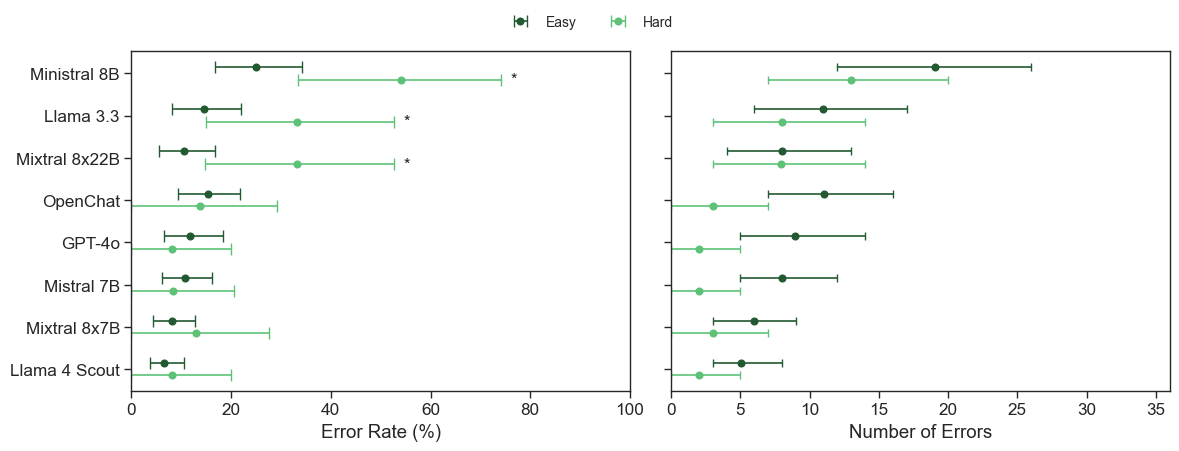

In [178]:
plot_error_rate_and_counts(df_results, figsize=(12, 4.5), filename='error_rate_and_counts')

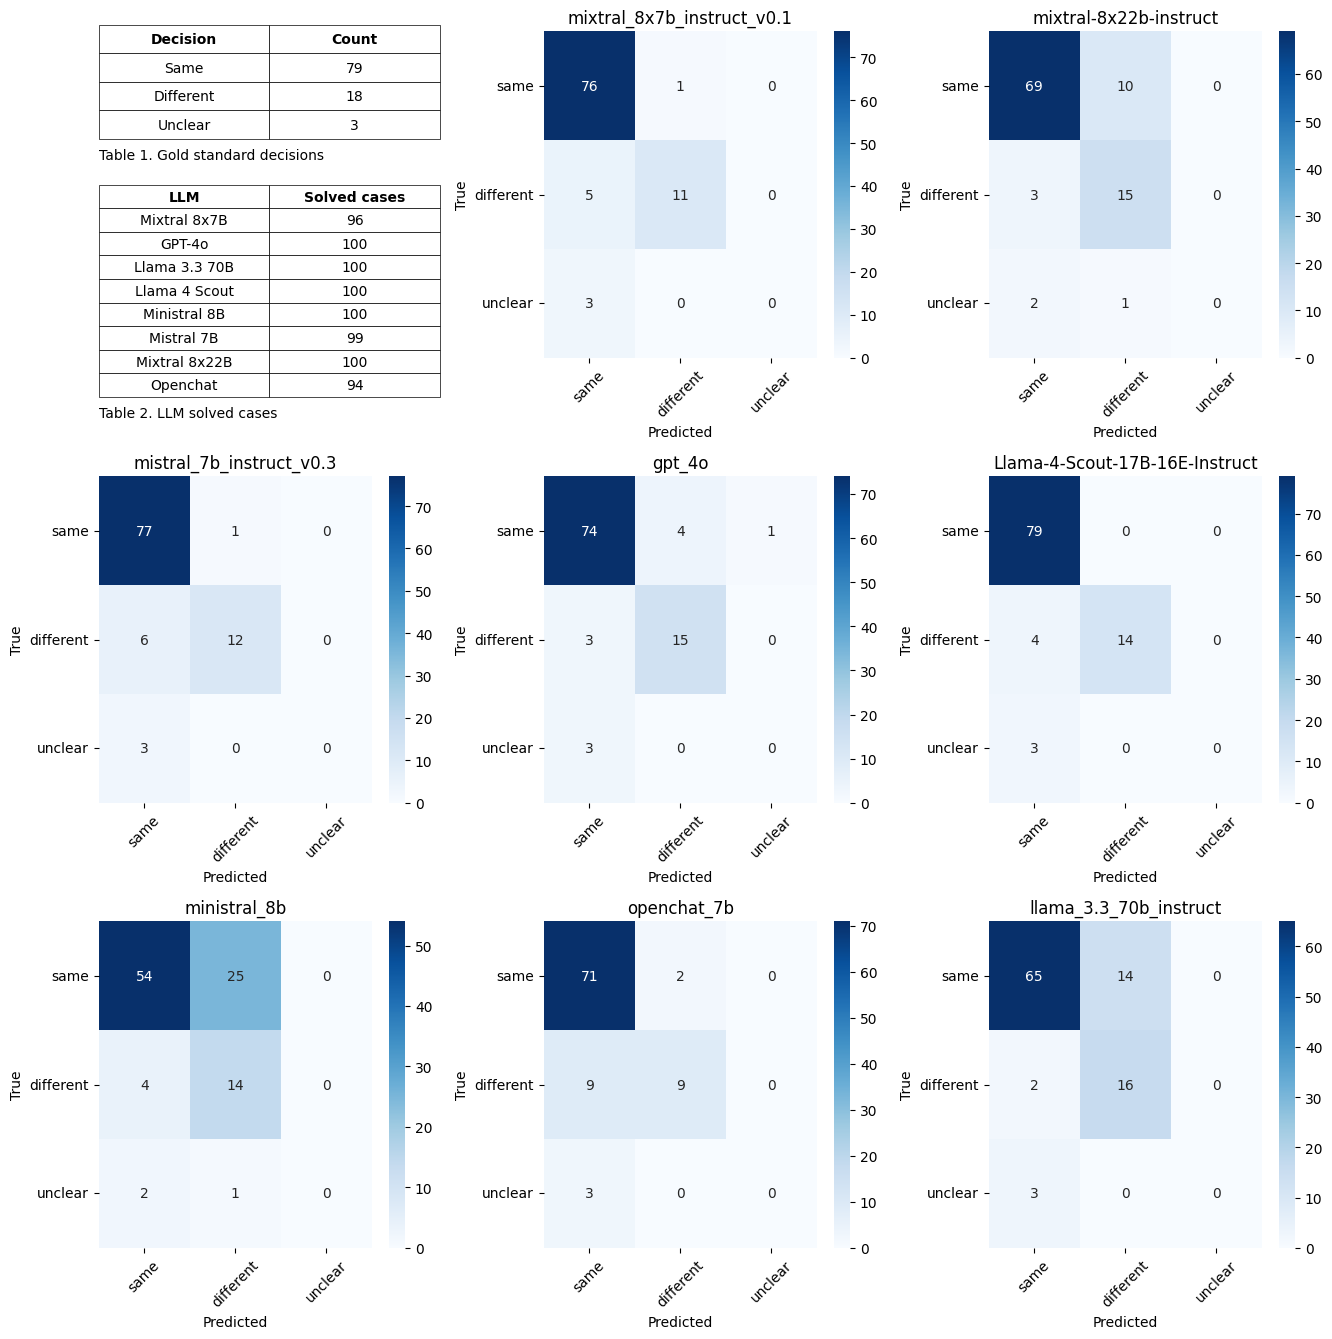

In [92]:
labels = ["same", "different", "unclear"]
n_models = len(confusion_matrices.keys())
n_cols = 3  # Customize grid layout
n_rows = int(np.ceil(n_models / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.5, n_rows * 4.5))
axes = axes.flatten()

# Insert table in the top-left subplot
axes[0].axis('off')  # Turn off the axis

# First table (higher position)
top_table_data = [["Decision", "Count"], ["Same", "79"], ["Different", "18"], ["Unclear", "3"]]


# Second table (lower position)
bottom_table_data =[
        ["LLM", "Solved cases"], 
        ["Mixtral 8x7B", "96"],
        ["GPT-4o", "100"],
        ["Llama 3.3 70B","100"],
        ["Llama 4 Scout", "100"], 
        ["Ministral 8B", "100"],
        ["Mistral 7B", "99"],
        ["Mixtral 8x22B",  "100"],
        ["Openchat", "94"]
        ]

# Draw the top table
table1 = axes[0].table(
    cellText=top_table_data,
    #loc='center',
    bbox=[0, 0.67, 1, 0.35]  # [left, bottom, width, height]
)
# Make headers bold
for (row, col), cell in table1.get_celld().items():
    if row == 0:  # Header row
        cell.get_text().set_fontweight('bold')
axes[0].text(0,  0.6 , "Table 1. Gold standard decisions", ha='left', va='bottom', fontsize=10, transform=axes[0].transAxes)


# Draw the bottom table
table2 = axes[0].table(
    cellText=bottom_table_data,
    #loc='center',
    bbox=[0, -0.12, 1, 0.65]
)
# Make headers bold
for (row, col), cell in table2.get_celld().items():
    if row == 0:
        cell.get_text().set_fontweight('bold')
axes[0].text(0, -0.19, "Table 2. LLM solved cases", ha='left', va='bottom', fontsize=10,  transform=axes[0].transAxes)


# Standardize style for both tables
for tbl in [table1, table2]:
    tbl.scale(1, 1.4)  # Adjust overall scaling
    for key, cell in tbl.get_celld().items():
        cell.set_fontsize(10)
        cell.set_linewidth(0.5)
        cell.set_text_props(ha='center', va='center')


for i, (model_name, conf_matrix) in enumerate(confusion_matrices.items()):
    ax = axes[i+1]
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=labels, yticklabels=labels)
    ax.set_title(model_name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_ylim(len(labels), 0)  # Reverse y-axis for better readability
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticklabels(labels, rotation=0)
    ax.grid(False)



plt.tight_layout()
plt.savefig("../figures/confusion_matrices_all_models.png", dpi=300, bbox_inches='tight')
plt.show()

## Agreement proxies

In [116]:
from collections import defaultdict, Counter
from scipy.stats import fisher_exact
import pandas as pd

def compute_model_agreement(model_paths, gold_path):
    # Load gold verdicts and difficulty labels
    gold_verdicts, hard_flags, _ = load_verdicts(gold_path)

    # Load all model predictions
    model_predictions = {}
    all_models = []

    for path in model_paths:
        model_name = Path(path).stem.replace("results_", "")
        preds, _, _ = load_verdicts(f'evaluation/{path}')
        model_predictions[model_name] = preds
        all_models.append(model_name)

    # Build agreement table per entry
    agreement_data = []
    for key in gold_verdicts:
        if key not in hard_flags:
            continue  # skip untagged gold entries

        votes = []
        for model in all_models:
            verdict = model_predictions.get(model, {}).get(key)
            if verdict:
                votes.append(verdict)

        if not votes:
            continue  # no votes at all

        vote_counts = Counter(votes)
        majority_label, majority_count = vote_counts.most_common(1)[0]
        is_correct = majority_label == gold_verdicts[key]
        is_hard = hard_flags[key]
        total_votes = len(votes)
        disagreement = total_votes - majority_count

        agreement_data.append({
            "entry": key,
            "total_votes": total_votes,
            "majority_label": majority_label,
            "majority_count": majority_count,
            "disagreement": disagreement,
            "is_correct": is_correct,
            "is_hard": is_hard
        })

    return pd.DataFrame(agreement_data)


def analyze_agreement_effect(df):
    print("\n🔍 Agreement-level error rates:")

    # Compute agreement level
    df["agreement_level"] = df["majority_count"] / df["total_votes"]

    # In two-model setup, 0.5 means no majority → no valid prediction
    df.loc[df["agreement_level"] == 0.5, "majority_label"] = np.nan

    # Show error rates by agreement level
    for level in sorted(df["agreement_level"].unique(), reverse=True):
        subset = df[df["agreement_level"] == level]
        if len(subset) < 3:
            continue  # skip small bins

        # Filter only entries where a prediction was made (i.e., not NaN)
        predicted = subset[subset["majority_label"].notna()]
        if len(predicted) == 0:
            print(f"Agreement {level:.2f} ({len(subset)} entries): No predictions made.")
            continue

        err_rate = 1 - predicted["is_correct"].mean()
        print(f"Agreement {level:.2f} ({len(predicted)} predictions): Error rate = {err_rate:.2%}")

    # Analyze error association with disagreement
    print("\n📊 Disagreement analysis:")
    agree = df[df["agreement_level"] == 1.0]
    disagree = df[df["agreement_level"] < 1.0]

    # Show disagreement cases
    print("\n📝 Disagreement cases:")
    print(disagree[["entry", "total_votes", "majority_count", "majority_label", "is_correct"]])

    # Optional: Fisher test, if still desired for completeness
    a = (agree["is_correct"] == False).sum()
    b = (agree["is_correct"] == True).sum()
    c = (disagree["is_correct"] == False).sum()
    d = (disagree["is_correct"] == True).sum()

    table = [[a, b], [c, d]]
    odds_ratio, p_value = fisher_exact(table)

    print("\n📊 Fisher test: Errors more likely in disagreement?")
    print(f"Contingency Table: {table}")
    print(f"Odds Ratio: {odds_ratio:.2f}")
    print(f"P-Value: {p_value:.4f}")

    return disagree

In [104]:
gold_path = "evaluation/human_results.jsonl"
promising_models_1 = [
    "results_mixtral_8x7b_instruct_v0.1.jsonl",
    "results_Llama-4-Scout-17B-16E-Instruct.jsonl",
    #"results_mistral_7b_instruct_v0.3.jsonl",
    #"results_gpt_4o.jsonl",
]

promising_models_2 = [
    "results_mixtral_8x7b_instruct_v0.1.jsonl",
    #"results_Llama-4-Scout-17B-16E-Instruct.jsonl",
    "results_mistral_7b_instruct_v0.3.jsonl",
    #"results_gpt_4o.jsonl",
]

promising_models_3 = [
    "results_mixtral_8x7b_instruct_v0.1.jsonl",
    "results_mixtral-8x22b-instruct.jsonl",
    #"results_Llama-4-Scout-17B-16E-Instruct.jsonl",
    #"results_mistral_7b_instruct_v0.3.jsonl",
    #"results_gpt_4o.jsonl",
]

promising_models_4 = [
    #"results_mixtral_8x7b_instruct_v0.1.jsonl",
    "results_mixtral-8x22b-instruct.jsonl",
    "results_Llama-4-Scout-17B-16E-Instruct.jsonl",
    #"results_mistral_7b_instruct_v0.3.jsonl",
    #"results_gpt_4o.jsonl",
]

promising_models_5 = [
    #"results_mixtral_8x7b_instruct_v0.1.jsonl",
    "results_mixtral-8x22b-instruct.jsonl",
    #"results_Llama-4-Scout-17B-16E-Instruct.jsonl",
    "results_mistral_7b_instruct_v0.3.jsonl",
    #"results_gpt_4o.jsonl",
]



model_paths_1 = [f"{name}" for name in promising_models_1]
model_paths_2 = [f"{name}" for name in promising_models_2]
model_paths_3 = [f"{name}" for name in promising_models_3]
model_paths_4 = [f"{name}" for name in promising_models_4]
model_paths_5 = [f"{name}" for name in promising_models_5]

print("Proxy 1. Mixtral 8B and Llama 4 Scout:")
df_agree_1 = compute_model_agreement(model_paths_1, gold_path)
analyze_agreement_effect(df_agree_1)

print('-------------------------------------------------------------')

print("\nProxy 2. Mistral 7B and Mixtral 8B:")
df_agree_2 = compute_model_agreement(model_paths_2, gold_path)
analyze_agreement_effect(df_agree_2)

print('-------------------------------------------------------------')

print("\nProxy 3. Mixtral 8B and Mixtral 8x22B:")
df_agree_3 = compute_model_agreement(model_paths_3, gold_path)
analyze_agreement_effect(df_agree_3)

print('-------------------------------------------------------------')

print("\nProxy 4.Llama 4 Scout and Mixtral 22B:")
df_agree_4 = compute_model_agreement(model_paths_4, gold_path)
analyze_agreement_effect(df_agree_4)

print('-------------------------------------------------------------')
print("\nProxy 5. Mistral 7B and Mixtral 22B:")
df_agree_5 = compute_model_agreement(model_paths_5, gold_path)
analyze_agreement_effect(df_agree_5)
print('-------------------------------------------------------------')



Proxy 1. Mixtral 8B and Llama 4 Scout:

🔍 Agreement-level error rates:
Agreement 1.00 (94 predictions): Error rate = 4.26%
Agreement 0.50 (3 entries): No predictions made.

📊 Disagreement analysis:

📝 Disagreement cases:
          entry  total_votes  majority_count majority_label  is_correct
18   escher/lib            2               1            NaN       False
41  xxmotif/cmd            2               1            NaN       False
83  minimap/cmd            2               1            NaN       False

📊 Fisher test: Errors more likely in disagreement?
Contingency Table: [[4, 90], [3, 0]]
Odds Ratio: 0.00
P-Value: 0.0002
-------------------------------------------------------------

Proxy 2. Mistral 7B and Mixtral 8B:

🔍 Agreement-level error rates:
Agreement 1.00 (93 predictions): Error rate = 5.38%
Agreement 0.50 (4 entries): No predictions made.

📊 Disagreement analysis:

📝 Disagreement cases:
          entry  total_votes  majority_count majority_label  is_correct
18   escher/lib 

In [67]:
df_agree_1[df_agree_1["disagreement"] > 0]

,entry,total_votes,majority_label,majority_count,disagreement,is_correct,is_hard,agreement_level
18,escher/lib,2,NaN,1,1,False,False,0.5
41,xxmotif/cmd,2,NaN,1,1,False,True,0.5
83,minimap/cmd,2,NaN,1,1,False,False,0.5


### Error and difficulty

In [105]:
def analyze_proxy_errors_vs_human_difficulty(df_agreement):
    # Focus only on errors
    errors = df_agreement[df_agreement["is_correct"] == False]

    # Count how many of those are hard for humans
    hard_errors = errors[errors["is_hard"] == True]
    easy_errors = errors[errors["is_hard"] == False]

    print(f"\n🔍 Agreement-based proxy made {len(errors)} total errors:")
    print(f"  → {len(hard_errors)} were marked as hard by humans ({len(hard_errors)/len(errors)*100:.1f}%)")
    print(f"  → {len(easy_errors)} were marked as easy by humans ({len(easy_errors)/len(errors)*100:.1f}%)")

    # Optional: return the actual rows for review
    return errors


In [106]:
analyze_proxy_errors_vs_human_difficulty(df_agree_1)
analyze_proxy_errors_vs_human_difficulty(df_agree_2)
analyze_proxy_errors_vs_human_difficulty(df_agree_3)
analyze_proxy_errors_vs_human_difficulty(df_agree_4)




🔍 Agreement-based proxy made 7 total errors:
  → 3 were marked as hard by humans (42.9%)
  → 4 were marked as easy by humans (57.1%)

🔍 Agreement-based proxy made 7 total errors:
  → 3 were marked as hard by humans (42.9%)
  → 4 were marked as easy by humans (57.1%)

🔍 Agreement-based proxy made 7 total errors:
  → 3 were marked as hard by humans (42.9%)
  → 4 were marked as easy by humans (57.1%)

🔍 Agreement-based proxy made 13 total errors:
  → 8 were marked as hard by humans (61.5%)
  → 5 were marked as easy by humans (38.5%)


,entry,total_votes,majority_label,majority_count,disagreement,is_correct,is_hard,agreement_level
13,sparsedossa2/lib,2,NaN,1,1,False,True,0.5
22,crossicc/lib,2,NaN,1,1,False,False,0.5
27,mendelscan/*,2,NaN,1,1,False,True,0.5
41,xxmotif/cmd,2,NaN,1,1,False,True,0.5
58,mapsplice/cmd,2,NaN,1,1,False,True,0.5
62,gffread/cmd,2,same,2,0,False,False,1.0
63,agotool/soap,2,NaN,1,1,False,False,0.5
67,export2graphlan/cmd,2,NaN,1,1,False,False,0.5
78,cmfinder/cmd,2,NaN,1,1,False,True,0.5
89,cryfa/cmd,2,NaN,1,1,False,False,0.5


### Accuracy, macro F1 and other metrics

In [117]:
import json
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

def compute_metrics_proxy(df_agree):
    # --- Load human results JSONL and flatten ---
    human_records = []
    with open("evaluation/human_results.jsonl", "r") as f:
        for line in f:
            obj = json.loads(line)
            for entry, values in obj.items():
                human_records.append({
                    "entry": entry,
                    "true_verdict": values.get("verdict", "").strip().lower()
                })

    df_gold = pd.DataFrame(human_records)

    # --- Merge proxy predictions with human gold labels ---
    df_merged = df_agree.merge(df_gold, on="entry")

    # --- Remove entries with no prediction ---
    df_merged = df_merged[df_merged["majority_label"].notna()]

    # --- Extract labels ---
    y_pred = df_merged["majority_label"]
    y_true = df_merged["true_verdict"]
    keys = df_merged["entry"]

    # --- Compute core metrics ---
    labels = ["same", "different", "unclear"]
    accuracy = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro", labels=labels, zero_division=0)
    kappa = cohen_kappa_score(y_true, y_pred)

    # --- Compute precision and recall ---
    precisions, recalls, _, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, zero_division=0
    )
    macro_precision = precisions.mean()
    macro_recall = recalls.mean()

    # --- Access per-class values if needed ---
    precision_same = precisions[0]
    recall_same = recalls[0]
    precision_different = precisions[1]
    recall_different = recalls[1]
    precision_unclear = precisions[2]
    recall_unclear = recalls[2]

    # --- Print or store summary ---
    print("Agreement Proxy Evaluation:")
    print(f"  Accuracy:          {accuracy:.3f}")
    print(f"  Macro F1-score:    {macro_f1:.3f}")
    print(f"  Cohen's Kappa:     {kappa:.3f}")
    print(f"  Macro Precision:   {macro_precision:.3f}")
    print(f"  Macro Recall:      {macro_recall:.3f}")
    print(f"  Precision (same):  {precision_same:.3f}")
    print(f"  Recall (same):     {recall_same:.3f}")
    print(f"  Precision (diff):  {precision_different:.3f}")
    print(f"  Recall (diff):     {recall_different:.3f}")
    print(f"  Precision (unclear): {precision_unclear:.3f}")
    print(f"  Recall (unclear):    {recall_unclear:.3f}")

    return y_true.tolist(), y_pred.tolist(), keys


def print_bootstrap_metrics_proxy(ci_results, name):
    print(f"\nConfidence Intervals for {name}:")
    print(f'Accuracy: {ci_results["accuracy_mean"]:.3f} ({ci_results["accuracy_ci_lower"]:.3f} – {ci_results["accuracy_ci_upper"]:.3f})')
    print(f'Macro F1: {ci_results["macro_f1_mean"]:.3f} ({ci_results["macro_f1_ci_lower"]:.3f} – {ci_results["macro_f1_ci_upper"]:.3f})')
    print(f'Macro Precision: {ci_results["macro_precision_mean"]:.3f} ({ci_results["macro_precision_ci_lower"]:.3f} – {ci_results["macro_precision_ci_upper"]:.3f})')
    print(f'Macro Recall: {ci_results["macro_recall_mean"]:.3f} ({ci_results["macro_recall_ci_lower"]:.3f} – {ci_results["macro_recall_ci_upper"]:.3f})')
    print(f"Precision (same): {ci_results['precision_same']:.3f} ({ci_results['precision_same_lower']:.3f} – {ci_results['precision_same_upper']:.3f})")
    print(f"Recall (same): {ci_results['recall_same']:.3f} ({ci_results['recall_same_lower']:.3f} – {ci_results['recall_same_upper']:.3f})")
    print(f"Precision (different): {ci_results['precision_different']:.3f} ({ci_results['precision_different_lower']:.3f} – {ci_results['precision_different_upper']:.3f})")
    print(f"Recall (different): {ci_results['recall_different']:.3f} ({ci_results['recall_different_lower']:.3f} – {ci_results['recall_different_upper']:.3f})")


def compute_for_proxy(df_agree, name):
    print(f'--------------------------{name}-----------------------------------')
    y_true, y_pred, keys = compute_metrics_proxy(df_agree)
    ci_result = bootstrap_metrics_stratified(y_true, y_pred, keys,  labels=["same", "different", "unclear"], n_bootstrap=1000, ci=95, random_state=42, rates = False)
    print(f"Bootstrap mean: {ci_result['accuracy_mean']:.3f}")
    print(f"Bootstrap CI: ({ci_result['accuracy_ci_lower']:.3f} - {ci_result['accuracy_ci_upper']:.3f})")
    print_bootstrap_metrics_proxy(ci_result, name)
    print('-------------------------------------------------------------')
    return ci_result


In [118]:
from copy import deepcopy

ci_result_1 = compute_for_proxy(deepcopy(df_agree_1), "Proxy V: Mixtral 8x7B and Llama 4 Scout")
ci_result_2 = compute_for_proxy(deepcopy(df_agree_2), "Proxy IV: Mistral 7B and Mixtral 8x7B")
ci_result_3 = compute_for_proxy(deepcopy(df_agree_3), "Proxy III: Mixtral 8x7B and Mixtral 8x22B")
ci_result_4 = compute_for_proxy(deepcopy(df_agree_4), "Proxy I: Llama 4 Scout and Mixtral 8x22B")
ci_result_5 = compute_for_proxy(deepcopy(df_agree_5), "Proxy II: Mistral 7B and Mixtral 8x22B")


--------------------------Proxy V: Mixtral 8x7B and Llama 4 Scout-----------------------------------
Agreement Proxy Evaluation:
  Accuracy:          0.957
  Macro F1-score:    0.611
  Cohen's Kappa:     0.833
  Macro Precision:   0.650
  Macro Recall:      0.583
  Precision (same):  0.951
  Recall (same):     1.000
  Precision (diff):  1.000
  Recall (diff):     0.750
  Precision (unclear): 0.000
  Recall (unclear):    0.000
Bootstrap mean: 0.958
Bootstrap CI: (0.926 - 0.989)

Confidence Intervals for Proxy V: Mixtral 8x7B and Llama 4 Scout:
Accuracy: 0.958 (0.926 – 0.989)
Macro F1: 0.611 (0.559 – 0.654)
Macro Precision: 0.651 (0.639 – 0.662)
Macro Recall: 0.585 (0.521 – 0.646)
Precision (same): 0.953 (0.918 – 0.987)
Recall (same): 1.000 (1.000 – 1.000)
Precision (different): 1.000 (1.000 – 1.000)
Recall (different): 0.756 (0.562 – 0.938)
-------------------------------------------------------------
--------------------------Proxy IV: Mistral 7B and Mixtral 8x7B-----------------------

In [149]:
def plot_horizontal_errorbars_referral(df, colors, filename="horizontal_metrics", size=(21, 6), total_cases=100):
    # Sort by accuracy for consistent ordering
    df = df.sort_values("accuracy", ascending=False)

    # Plot style
    sns.set_theme(style="ticks", context="paper", font_scale=1.4)

    # Extract colors from the palette
    color_acc = colors[0]
    color_f1 = colors[1]
    color_def = colors[2] if len(colors) > 2 else "tab:gray"

    # Compute deferral rate
    df["deferral_rate"] = df["skipped_entries"] / total_cases * 100

    # Create subplots
    fig, axes = plt.subplots(
        nrows=1, ncols=3, figsize=size,
        sharey=True,
        gridspec_kw={'width_ratios': [1, 1, 0.5]}
    )

    # --- Accuracy ---
    axes[0].errorbar(
        df['accuracy'], df['model'],
        xerr=[df['accuracy'] - df['accuracy_lower'], df['accuracy_upper'] - df['accuracy']],
        fmt='o', capsize=4, color=color_acc
    )
    axes[0].set_title("Accuracy with 95% CI")
    axes[0].set_xlim(0.5, 1.0)
    axes[0].set_xlabel("Score")

    # --- Macro F1-score ---
    axes[1].errorbar(
        df['macro_f1'], df['model'],
        xerr=[df['macro_f1'] - df['macro_f1_lower'], df['macro_f1_upper'] - df['macro_f1']],
        fmt='o', capsize=4, color=color_f1
    )
    axes[1].set_title("Macro F1-score with 95% CI")
    axes[1].set_xlim(0.0, 1.0)
    axes[1].set_xlabel("Score")

    # --- Deferral Rate (no error bar, direct value) ---
    axes[2].barh(df['model'], df['deferral_rate'], color=color_def)
    axes[2].set_title("Deferral Rate (%)")
    axes[2].set_xlim(0, 20)
    axes[2].set_xlabel("Percentage")

    # Layout and save
    plt.tight_layout()
    plt.savefig(f"../figures/{filename}.png", dpi=300, bbox_inches='tight')
    plt.show()

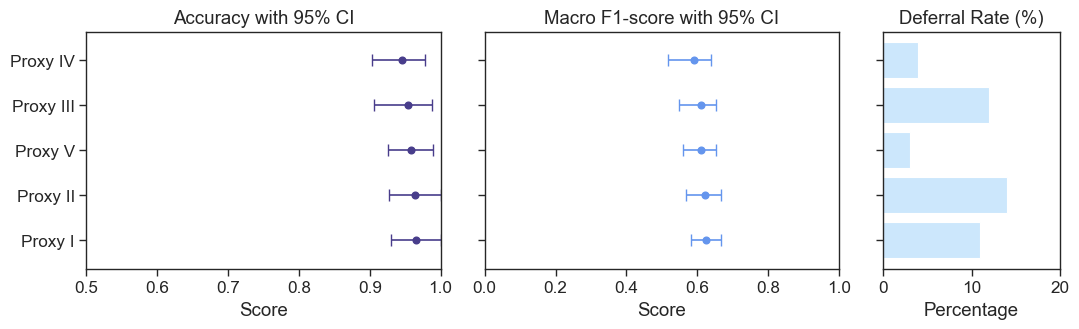

In [150]:
proxies_summary = []
proxies = {
    "Proxy V": ci_result_1,
    "Proxy IV": ci_result_2,
    "Proxy III": ci_result_3,
    "Proxy I": ci_result_4,
    "Proxy II": ci_result_5
}

NaNs = {
    "Proxy V": df_agree_1['majority_label'].isna().sum(),
    "Proxy IV": df_agree_2['majority_label'].isna().sum(),
    "Proxy III": df_agree_3['majority_label'].isna().sum(),
    "Proxy I": df_agree_4['majority_label'].isna().sum(),
    "Proxy II": df_agree_5['majority_label'].isna().sum()
}

for name, result in proxies.items():
    proxies_summary.append({
        "model": name,
        "skipped_entries": NaNs[name],
        "accuracy": result["accuracy_mean"],
        "accuracy_lower": result["accuracy_ci_lower"],
        "accuracy_upper": result["accuracy_ci_upper"],
        "macro_f1": result["macro_f1_mean"],
        "macro_f1_lower": result["macro_f1_ci_lower"],
        "macro_f1_upper": result["macro_f1_ci_upper"]
    })

proxies_summary_df = pd.DataFrame(proxies_summary)

# plot horizontal error bars for proxies
plot_horizontal_errorbars_referral(proxies_summary_df, ['darkslateblue','cornflowerblue', '#cce7fc'], 'proxies_accuracy_macro_f1', size=(11, 3.5))
    


Agreement Proxy Evaluation:
  Accuracy:          0.928
  Macro F1-score:    0.866
  Cohen’s Kappa:     0.733
  Macro Precision:   0.617
  Macro Recall:      0.551
  Precision (same):  0.929
  Recall (same):     0.987
  Precision (diff):  0.923
  Recall (diff):     0.667
  Precision (unclear): 0.000
  Recall (unclear):    0.000

## Cost

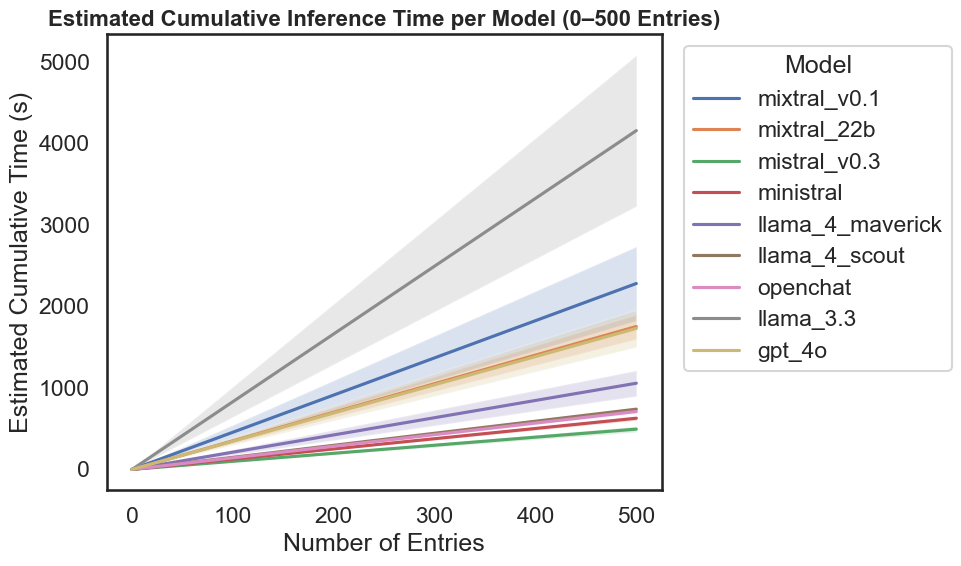

In [90]:
import os
import glob
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import sem, t

# List of model names you want to include
models = [
    "mixtral_v0.1", "mixtral_22b", "mistral_v0.3", "ministral",
    "llama_4_maverick", "llama_4_scout", "openchat", "llama_3.3", "gpt_4o"
]

model_path_dict = {
    "mixtral_v0.1": "raw_mixtral_8x7b_instruct_v0.1_results", 
    "mixtral_22b": "raw_mixtral-8x22b-instruct_results", 
    "mistral_v0.3": "raw_mistral_7b_instruct_v0.3_results", 
    "ministral": "raw_ministral_8b_results",
    "llama_4_maverick": "raw_Llama-4-Maverick-17B-128E-Instruct_results", 
    "llama_4_scout": "raw_Llama-4-Scout-17B-16E-Instruct_results", 
    "openchat": "raw_openchat_7b_results", 
    "llama_3.3": "raw_llama_3.3_70b_instruct_results", 
    "gpt_4o": "raw_gpt_4o_results"
}


# Collect data
model_times_dict = defaultdict(list)
for model in models:
    times = []
    folder = model_path_dict[model]
    for path in glob.glob(os.path.join(folder, "meta_*.json")):
        with open(path, "r") as f:
            data = json.load(f)
            time = data.get("total_time", None)
            times.append(float(time) if time is not None else None)

    model_times_dict[model] = times

# Step 1: Collect all times
model_times_dict = defaultdict(list)
for model in models:
    folder = model_path_dict[model]
    for path in glob.glob(os.path.join(folder, "meta_*.json")):
        with open(path, "r") as f:
            data = json.load(f)
            time = data.get("total_time", None)
            if time is not None:
                model_times_dict[model].append(float(time))

# Step 2: Compute mean and confidence interval for each model
summary = []
for model, times in model_times_dict.items():
    times = np.array(times)
    mean = np.mean(times)
    n = len(times)
    ci = t.ppf(0.975, n-1) * sem(times) if n > 1 else 0
    summary.append({
        "model": model,
        "mean_time": mean,
        "ci": ci,
        "n": n
    })

summary_df = pd.DataFrame(summary)

# Step 3: Simulate cumulative time for 0 to 1000 entries using mean ± CI
records = []
max_entries = 500

for _, row in summary_df.iterrows():
    for k in range(0, max_entries + 1):
        records.append({
            "model": row["model"],
            "entries": k,
            "cumulative_time": k * row["mean_time"],
            "lower": k * (row["mean_time"] - row["ci"]),
            "upper": k * (row["mean_time"] + row["ci"]),
        })

plot_df = pd.DataFrame(records)

# Step 4: Plot using seaborn
sns.set_theme(style="white", context="talk")
plt.figure(figsize=(10, 6))

ax = sns.lineplot(data=plot_df, x="entries", y="cumulative_time", hue="model")

# Add confidence interval shading
for model in plot_df["model"].unique():
    subset = plot_df[plot_df["model"] == model]
    plt.fill_between(
        subset["entries"],
        subset["lower"],
        subset["upper"],
        alpha=0.2
    )

ax.set_title("Estimated Cumulative Inference Time per Model (0–500 Entries)", fontsize=16, weight='bold')
ax.set_xlabel("Number of Entries")
ax.set_ylabel("Estimated Cumulative Time (s)")
plt.legend(title="Model", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()



In [91]:
summary_df
# save summary_df to CSV
summary_df.to_csv("model_inference_times.csv", index=False)

In [92]:
import pandas as pd
import numpy as np
from scipy.stats import t, sem

# Input data
data = pd.DataFrame({
    "entries": [10, 20, 50, 70, 77, 100],
    "total_time": [1200, 2400, 5040, 6840, 7980, 11580]
})

# Compute time per entry
data["time_per_entry"] = data["total_time"] / data["entries"]

# Mean and CI
mean_human = data["time_per_entry"].mean()
n = len(data)
std_err = sem(data["time_per_entry"])
conf_int = t.ppf(0.975, n - 1) * std_err

print(f"Mean time per entry: {mean_human:.2f} s")
print(f"95% confidence interval: ±{conf_int:.2f} s")

Mean time per entry: 109.66 s
95% confidence interval: ±10.59 s


In [93]:
human_curve = pd.DataFrame({
    "model": "Human",
    "entries": np.arange(0, 501),
    "cumulative_time": np.arange(0, 501) * mean_human,
    "lower": np.arange(0, 501) * (mean_human - ci),
    "upper": np.arange(0, 501) * (mean_human + ci)
})

In [94]:
plot_df["model"] = "AI"
# save the AI curve
plot_df.to_csv("ai_curve.csv", index=False)

In [95]:
# Group all models under 'AI'
plot_df["model"] = "AI"

# Combine with human
combined_df = pd.concat([plot_df, human_curve], ignore_index=True)


In [96]:
combined_df = pd.concat([plot_df, human_curve], ignore_index=True)
combined_df

,model,entries,cumulative_time,lower,upper
0,AI,0,0.000000,0.000000,0.000000
1,AI,1,4.561579,3.652515,5.470643
2,AI,2,9.123158,7.305029,10.941287
3,AI,3,13.684737,10.957544,16.411930
4,AI,4,18.246316,14.610058,21.882573
...,...,...,...,...,...
5005,Human,496,54390.587013,54164.308328,54616.865698
5006,Human,497,54500.245455,54273.510562,54726.980347
5007,Human,498,54609.903896,54382.712797,54837.094995
5008,Human,499,54719.562338,54491.915031,54947.209644


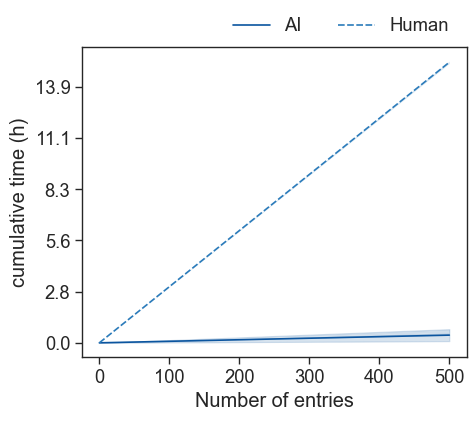

In [ ]:
import matplotlib.ticker as ticker

sns.set_theme(style="ticks", context="paper", palette="Blues_r", font_scale=1.5)

# Plot with Seaborn's CI calculation
plt.figure(figsize=(5, 4.5))
ax = sns.lineplot(
    data=combined_df,
    x="entries",
    y="cumulative_time",
    hue="model",
    errorbar="sd",        # or ci=95
    estimator="mean",
    style="model"
)

# Add confidence bands (including Human)
for model in combined_df["model"].unique():
    subset = combined_df[combined_df["model"] == model]
    if "lower" in subset and "upper" in subset:
        plt.fill_between(
            subset["entries"],
            subset["lower"],
            subset["upper"],
            alpha=0.2
        )

# Format y-axis to show hours
formatter = ticker.FuncFormatter(lambda x, pos: f'{x / 3600:.1f}')
ax.yaxis.set_major_formatter(formatter)

ax.set_xlabel("Number of entries")
ax.set_ylabel("cumulative time (h)")
plt.legend(title="", loc="upper left", bbox_to_anchor=(0.35, 1.15), ncol=2, frameon=False)


plt.tight_layout()
plt.savefig("../figures/cumulative_time_comparison.png", dpi=300, bbox_inches='tight')
plt.show()


### Times of inference for human, agreement proxies and llama scout 4

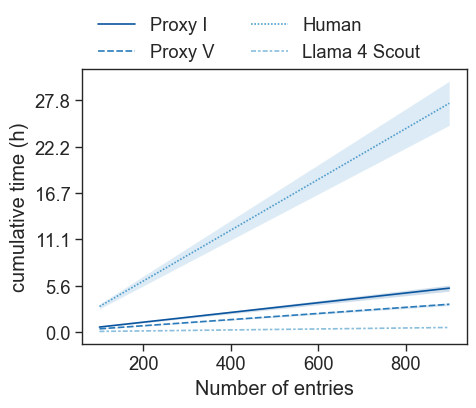

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# --- Inference times and constants ---
llama4_time = 2.114085
mixtral_22b_time = 3.505876
mixtral_7b_time = 4.561579

human_mean = 109.66
human_ci = 10.59

# --- Entry range ---
entry_counts = np.arange(100, 1000, 100)

# --- Proxy setup ---
proxies = {
    "Proxy I": {
        "models": [llama4_time, mixtral_22b_time],
        "human_fraction": 0.14
    },
    "Proxy V": {
        "models": [llama4_time, mixtral_7b_time],
        "human_fraction": 0.06
    }
}

# --- Build Proxy data ---
records = []
for proxy_name, proxy in proxies.items():
    for n in entry_counts:
        model_total = sum(proxy["models"]) * n
        human_total = human_mean * proxy["human_fraction"] * n
        total = model_total + human_total
        human_total_ci = human_ci * proxy["human_fraction"] * n
        lower = model_total + (human_total - human_total_ci)
        upper = model_total + (human_total + human_total_ci)

        records.append({
            "entries": n,
            "cumulative_time": total,
            "lower": lower,
            "upper": upper,
            "model": proxy_name
        })

# --- Add Human and AI (Llama 4 scout) baselines ---
baselines = [
    {"model": "Human", "time_per_entry": human_mean, "ci": human_ci},
    {"model": "Llama 4 Scout", "time_per_entry": llama4_time, "ci": 0}
]

for baseline in baselines:
    for n in entry_counts:
        time = baseline["time_per_entry"] * n
        ci = baseline["ci"] * n
        records.append({
            "entries": n,
            "cumulative_time": time,
            "lower": time - ci,
            "upper": time + ci,
            "model": baseline["model"]
        })

combined_df = pd.DataFrame(records)

# --- PLOT ---
sns.set_theme(style="ticks", context="paper", palette="Blues_r", font_scale=1.5)

plt.figure(figsize=(5, 4.5))
ax = sns.lineplot(
    data=combined_df,
    x="entries",
    y="cumulative_time",
    hue="model",
    errorbar=None,
    estimator=None,
    style="model"
)

# Add confidence bands
for model in combined_df["model"].unique():
    subset = combined_df[combined_df["model"] == model]
    plt.fill_between(
        subset["entries"],
        subset["lower"],
        subset["upper"],
        alpha=0.2
    )

# Format y-axis to show hours
formatter = ticker.FuncFormatter(lambda x, pos: f'{x / 3600:.1f}')
ax.yaxis.set_major_formatter(formatter)

ax.set_xlabel("Number of entries")
ax.set_ylabel("cumulative time (h)")
plt.legend(title="", loc="upper left", bbox_to_anchor=(0.0, 1.25), ncol=2, frameon=False)

plt.tight_layout()
plt.savefig("../figures/cumulative_time_comparison_llama4.png", dpi=300, bbox_inches='tight')
plt.show()

In [104]:
combined_df

,entries,cumulative_time,lower,upper,model
0,100,2097.2361,1948.9761,2245.4961,Proxy I
1,200,4194.4722,3897.9522,4490.9922,Proxy I
2,300,6291.7083,5846.9283,6736.4883,Proxy I
3,400,8388.9444,7795.9044,8981.9844,Proxy I
4,500,10486.1805,9744.8805,11227.4805,Proxy I
5,600,12583.4166,11693.8566,13472.9766,Proxy I
6,700,14680.6527,13642.8327,15718.4727,Proxy I
7,800,16777.8888,15591.8088,17963.9688,Proxy I
8,900,18875.1249,17540.7849,20209.4649,Proxy I
9,100,1325.5264,1261.9864,1389.0664,Proxy V


## Gold standard distributions

/var/folders/kh/9snwv84s4bz5r1lt7vhqhr_m0000gn/T/ipykernel_71969/4265690500.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0], data=df, x="verdict",
/var/folders/kh/9snwv84s4bz5r1lt7vhqhr_m0000gn/T/ipykernel_71969/4265690500.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[1], data=df, x="confidence",


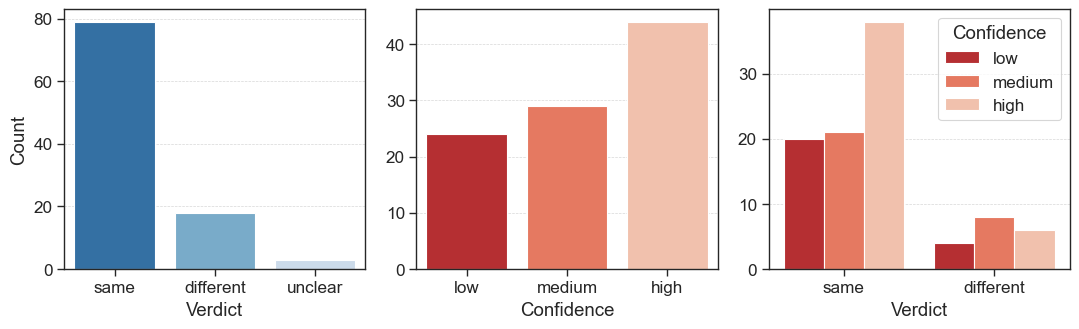

In [99]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def add_bar_labels(ax, fmt="{:.0f}", padding=4, fontsize=11):
    for container in ax.containers:
        ax.bar_label(container, labels=[fmt.format(p.get_height()) for p in container],
                     padding=padding, fontsize=fontsize)

# --- Load and flatten the JSONL ---
records = []
with open("evaluation/human_results.jsonl", "r") as f:
    for line in f:
        try:
            obj = json.loads(line)
            for tool_id, annotation in obj.items():
                records.append({
                    "tool": tool_id,
                    "verdict": annotation.get("verdict", ""),
                    "confidence": annotation.get("confidence", "")
                })
        except json.JSONDecodeError:
            continue

df = pd.DataFrame(records)

# --- Prepare figure ---
sns.set_theme(style="ticks", context="paper", font_scale=1.4)
fig, axes = plt.subplots(1, 3, figsize=(11, 3.5))

# --- Plot 1: Verdict distribution ---
sns.countplot(ax=axes[0], data=df, x="verdict",
              order=["same", "different", "unclear"],
              palette="Blues_r")
axes[0].set_title("")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("Verdict")
axes[0].grid(axis='y', color='lightgray', linestyle='--', linewidth=0.5, alpha=0.9)


# --- Plot 2: Confidence distribution ---
sns.countplot(ax=axes[1], data=df, x="confidence",
              order=["low", "medium", "high"],
              palette="Reds_r")
axes[1].set_title("")
axes[1].set_ylabel("")
axes[1].set_xlabel("Confidence")
axes[1].grid(axis='y', color='lightgray', linestyle='--', linewidth=0.5, alpha=0.9)


# --- Plot 3: Verdict × Confidence (excluding unclear) ---
df_filtered = df[df["verdict"] != "unclear"]
sns.countplot(ax=axes[2], data=df_filtered, x="verdict", hue="confidence",
              order=["same", "different"],
              hue_order=["low", "medium", "high"],
              palette="Reds_r")
axes[2].set_title("")
axes[2].set_ylabel("")
axes[2].set_xlabel("Verdict")
axes[2].legend(title="Confidence", loc="upper right")
axes[2].grid(axis='y', color='lightgray', linestyle='--', linewidth=0.5, alpha=0.9)

# --- Final touches ---
plt.tight_layout()
plt.savefig("../figures/gold_standard_distributions.png", dpi=300)
plt.show()

In [ ]:
df['verdict'].value_counts()

NameError: name 'df' is not defined